In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import numpy as np
import scipy as sp
import os
from scipy.linalg import fractional_matrix_power

from jax import vmap, jit, numpy as jnp, random, lax, jvp, scipy as jsp
import matplotlib.pyplot as plt
import pickle
from functools import reduce

import matplotlib.animation as animation
from IPython.display import HTML

module_path = os.path.abspath(os.path.join("/burg/ccce/users/su2254/ad_afqmc"))
if module_path not in sys.path:
    sys.path.append(module_path)

from ad_afqmc import lattices

from pyscf import fci, gto, scf, mp, ao2mo

import itertools
from functools import partial

np.set_printoptions(precision=5, suppress=True)

/burg/ccce/users/su2254/envs/ad_afqmc/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Check triangular lattice with `open_x` boundary condition

In [3]:
lattice = lattices.triangular_grid(6, 6, boundary_condition='open_x')
n_sites = lattice.n_sites
coords = np.array([lattice.get_site_coordinate(site) for site in lattice.sites])

In [4]:
adj_mat = lattice.create_adjacency_matrix()

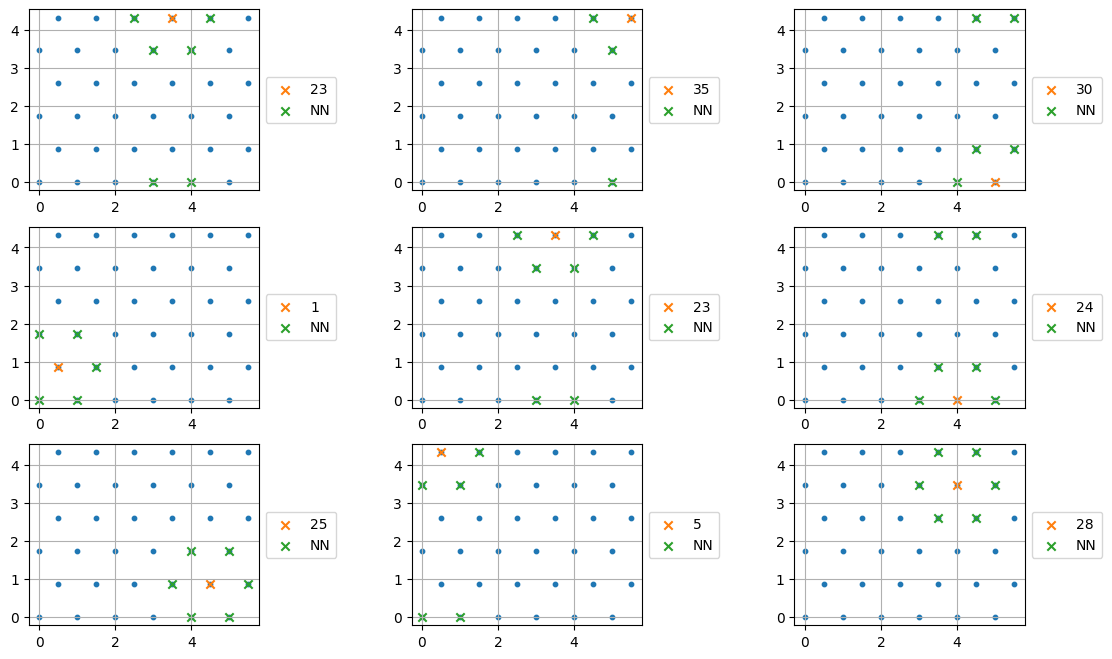

In [5]:
fig, axs = plt.subplots(3, 3, figsize=(14, 8))
axs = axs.flatten()

for i in range(9):
    ax = axs[i]
    idx = np.random.randint(0, n_sites)
    nn_idx = np.where(adj_mat[idx])[0]
    nn_coords = np.array([lattice.get_site_coordinate_from_num(idx) for idx in nn_idx])

    ax.scatter(coords[:, 0], coords[:, 1], marker='o', s=10)
    ax.scatter(coords[idx, 0], coords[idx, 1], marker='x', label=idx)
    ax.scatter(nn_coords[:, 0], nn_coords[:, 1], marker='x', label='NN')

    ax.grid()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_aspect('equal')

# Check triangular lattice with `opbc` boundary condition

In [6]:
lattice = lattices.triangular_grid(6, 6, boundary_condition='opbc')
n_sites = lattice.n_sites
coords = np.array([lattice.get_site_coordinate(site) for site in lattice.sites])

In [7]:
adj_mat = lattice.create_adjacency_matrix()

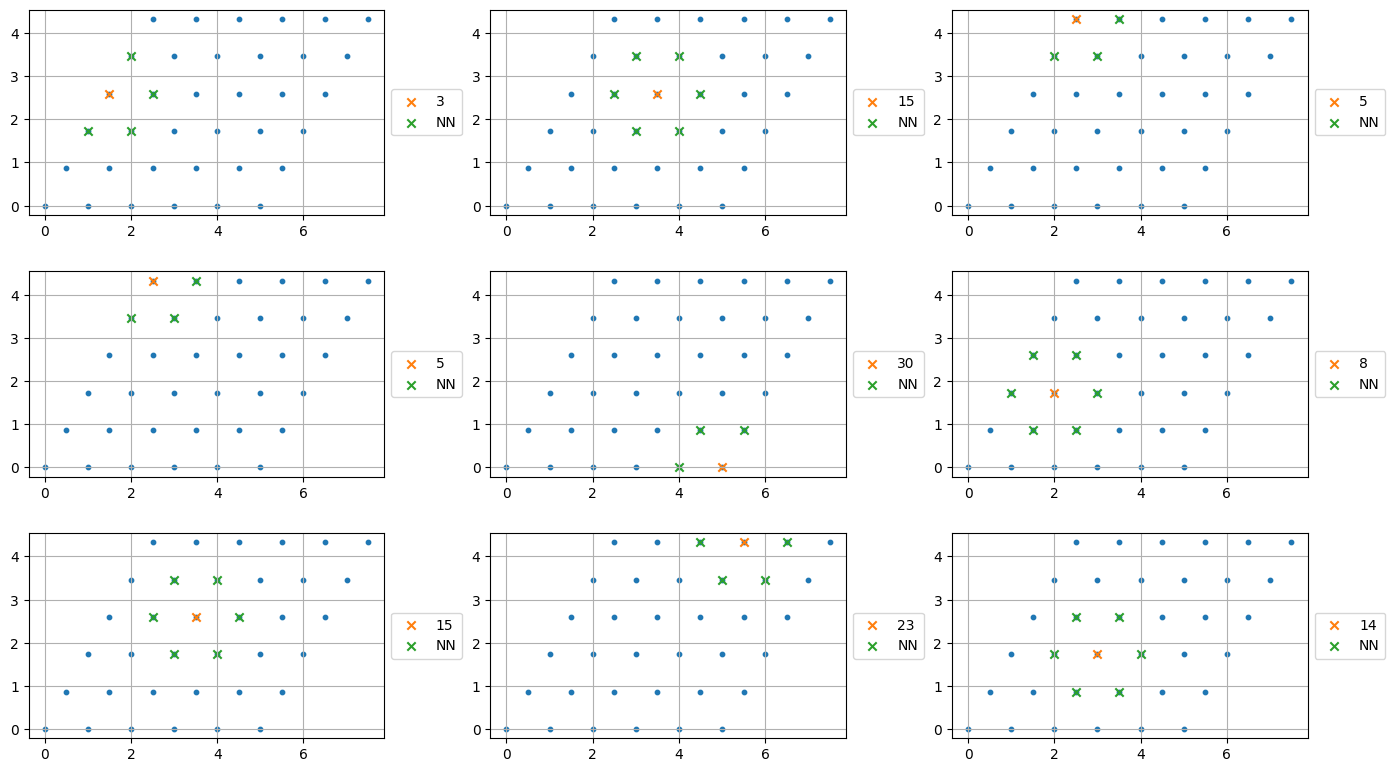

In [8]:
fig, axs = plt.subplots(3, 3, figsize=(14, 8))
axs = axs.flatten()

for i in range(9):
    ax = axs[i]
    idx = np.random.randint(0, n_sites)
    nn_idx = np.where(adj_mat[idx])[0]
    nn_coords = np.array([lattice.get_site_coordinate_from_num(idx) for idx in nn_idx])

    ax.scatter(coords[:, 0], coords[:, 1], marker='o', s=10)
    ax.scatter(coords[idx, 0], coords[idx, 1], marker='x', label=idx)
    ax.scatter(nn_coords[:, 0], nn_coords[:, 1], marker='x', label='NN')

    ax.grid()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_aspect('equal')

plt.tight_layout()

# Check rectangular lattice with `open_x` boundary condition

In [9]:
lattice = lattices.two_dimensional_grid(6, 6, open_x=True)
n_sites = lattice.n_sites
coords = np.array(lattice.sites)

In [5]:
adj_mat = lattice.create_adjacency_matrix()

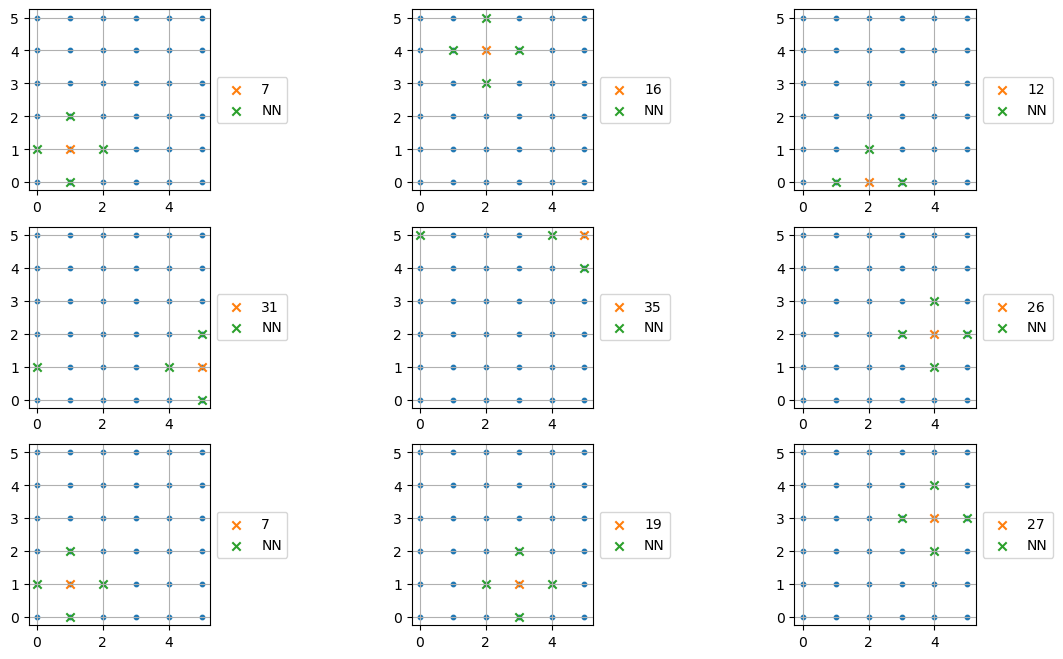

In [11]:
fig, axs = plt.subplots(3, 3, figsize=(14, 8))
axs = axs.flatten()

for i in range(9):
    ax = axs[i]
    idx = np.random.randint(0, n_sites)
    nn_idx = np.where(adj_mat[idx])[0]
    nn_coords = np.array([coords[idx] for idx in nn_idx])

    ax.scatter(coords[:, 0], coords[:, 1], marker='o', s=10)
    ax.scatter(coords[idx, 0], coords[idx, 1], marker='x', label=idx)
    ax.scatter(nn_coords[:, 0], nn_coords[:, 1], marker='x', label='NN')

    ax.grid()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_aspect('equal')